# accessing data

In [80]:
# !ls
# !pip install pandas
# !pip install scikit-learn
# !pip install matplotlib
# !pip install xarray
# !pip install gcsfs
# !pip install tqdm
# !pip install numpy

import torch
print(hasattr(torch.Tensor, 'numpy'))


True


In [4]:
import pandas as pd

df = pd.read_csv("/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/FPA-FOD_reduced.csv", low_memory = False)
df = df.drop('Unnamed: 0', axis = 'columns') #drops the items where columns are unnamed

# Processing data

In [5]:
unknown_mask = df['NWCG_GENERAL_CAUSE'] == "Missing data/not specified/undetermined"

df_known = df[~unknown_mask].copy()
df_unknown = df[unknown_mask].copy()

In [ ]:
X = df_known.drop(columns=['NWCG_GENERAL_CAUSE'])
y = df_known['NWCG_GENERAL_CAUSE']

1            Debris and open burning
2          Misuse of fire by a minor
3          Equipment and vehicle use
4                          Fireworks
6            Debris and open burning
                     ...            
2302516    Equipment and vehicle use
2302517           Arson/incendiarism
2302518                      Smoking
2302519           Arson/incendiarism
2302520      Debris and open burning
Name: NWCG_GENERAL_CAUSE, Length: 1704940, dtype: object

In [ ]:
X = X.fillna(X.median(numeric_only=True)) #replace NANs

for col in X.columns: #convert numeric values to floats, if possible
    if X[col].dtype == 'object':
        # try converting to float — if it works, keep it numeric
        try:
            X[col] = X[col].astype(float)
        except ValueError:
            pass

,pr,tmmn,tmmx,rmin,rmax,sph,srad,etr,vpd,bi,...,Aridity_index,Population,GDP,LATITUDE,LONGITUDE,STATE,COUNTY,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME
1,0.0,269.299988,281.799988,36.700001,92.099998,0.00282,129.100006,2.2,0.35,28.0,...,0.58,0.0165,47810.750,32.360830,-98.089850,TX,Erath,2007,1,1455.0
2,0.0,276.500000,287.299988,41.799999,90.000000,0.00448,132.900009,3.6,0.47,38.0,...,0.16,2.6456,55688.996,36.487061,-121.934647,CA,Monterey,2007,1,1537.0
3,0.0,275.100006,286.700012,23.900000,75.200005,0.00323,144.300003,3.1,0.61,29.0,...,0.58,1.1297,47810.750,28.893870,-98.538850,TX,Atascosa,2007,1,1455.0
4,0.9,288.299988,300.299988,49.000000,98.200005,0.01116,109.500000,4.5,0.85,0.0,...,0.48,0.1981,50591.914,27.508610,-80.758610,FL,Okeechobee,2007,1,1022.0
6,0.0,269.600006,282.399994,29.100000,79.700005,0.00250,136.900009,2.7,0.44,34.0,...,0.36,1.6947,47810.750,31.424140,-100.292500,TX,Tom Green,2007,1,1455.0


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y) #encode the textual output

array([ 1,  5,  2, ..., 11,  0,  1])

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_features = ['pr', 'tmmn', 'tmmx', 'rmin', 'rmax', 'sph', 'srad', 'etr', 'vpd',
                    'bi', 'erc', 'fm100', 'fm1000', 'EVC', 'EVT', 'EVH',
                    'Elevation', 'Slope', 'Aspect', 'TRI', 'TPI', 'Aridity_index',
                    'Population', 'GDP', 'LATITUDE', 'LONGITUDE', 'FIRE_YEAR','DISCOVERY_DOY', 'DISCOVERY_TIME']

categorical_features = ['STATE', 'COUNTY']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split train test

### Evenly Balanced

In [ ]:
# from sklearn.model_selection import train_test_split

# # Combine X and y into one DataFrame temporarily
# df2 = X.copy()

# df2['cause'] = y_encoded

# df_balanced = (
#     df2.groupby('cause', group_keys=False)
#       .apply(lambda x: x.sample(n=min(len(x), 10000), random_state=42))
#       .reset_index(drop=True)
# )

# # Split back into X and y
# X_balanced = df_balanced.drop(columns=['cause'])
# y_balanced = df_balanced['cause']

# # Now do your train-test split as usual
# X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
#     X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
# )

# print(X_train_df.shape, X_test_df.shape)
# print(y_train_df.value_counts())

/var/folders/9p/1xc4qsqs6wv7ng86fqksqfrr0000gn/T/ipykernel_87485/731912646.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2.groupby('cause', group_keys=False)


(90186, 32) (22547, 32)
cause
11    8000
6     8000
10    8000
8     8000
0     8000
7     8000
2     8000
4     8000
1     8000
5     8000
9     8000
3     2186
Name: count, dtype: int64


Balanced by initial distribution

In [32]:
from sklearn.model_selection import train_test_split

# Combine X and y
df2 = X.copy()
df2['cause'] = y_encoded

# Calculate per-class limits (as you did before)
limits = (df2['cause'].value_counts() / 10).round(0)

# Sample per-class, capped at the class-specific limit
df_balanced = (
    df2.groupby('cause', group_keys=False)
       .apply(lambda x: x.sample(n=int(min(len(x), limits.loc[x.name])), random_state=42))
       .reset_index(drop=True)
)

# Split back into X and y
X_balanced = df_balanced.drop(columns=['cause'])
y_balanced = df_balanced['cause']

# Usual train-test split, stratified
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(X_train_df.shape, X_test_df.shape)
print(y_train_df.value_counts())


/var/folders/9p/1xc4qsqs6wv7ng86fqksqfrr0000gn/T/ipykernel_87485/2585580308.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2.groupby('cause', group_keys=False)


(136395, 32) (34099, 32)
cause
1     42841
6     26182
0     25654
2     15215
10     7957
5      5302
11     5102
9      2982
8      2612
4      1488
7       842
3       218
Name: count, dtype: int64


In [33]:
## Turning the filed into CSV

X_train_df.to_csv("X_train_initial_distr.csv", index=False)
X_test_df.to_csv("X_test_initial_distr.csv", index=False)
y_train_df.to_csv("y_train_initial_distr.csv", index=False)
y_test_df.to_csv("y_test_initial_distr.csv", index=False)

In [28]:
cause_names = [
    "Debris and open burning",
    "Misuse of fire by a minor",
    "Equipment and vehicle use",
    "Fireworks",
    "Arson/incendiarism",
    "Power generation/transmission/distribution",
    "Railroad operations and maintenance",
    "Recreation and ceremony",
    "Natural",
    "Smoking",
    "Other causes",
    "Firearms and explosives use"
]

# Convert y_train value counts into a DataFrame for easier mapping
counts = y_train_df.value_counts().reset_index()
counts.columns = ['cause_id', 'count']

# Map encoded ID to name
counts['cause_name'] = counts['cause_id'].map(lambda i: cause_names[i])

print(counts[['cause_id', 'cause_name', 'count']].to_string(index=False))

 cause_id                                 cause_name  count
        1                  Misuse of fire by a minor  42841
        6        Railroad operations and maintenance  26182
        0                    Debris and open burning  25654
        2                  Equipment and vehicle use  15215
       10                               Other causes   7957
        5 Power generation/transmission/distribution   5302
       11                Firearms and explosives use   5102
        9                                    Smoking   2982
        8                                    Natural   2612
        4                         Arson/incendiarism   1488
        7                    Recreation and ceremony    842
        3                                  Fireworks    218


In [29]:
X_train_df.head()

,pr,tmmn,tmmx,rmin,rmax,sph,srad,etr,vpd,bi,...,Aridity_index,Population,GDP,LATITUDE,LONGITUDE,STATE,COUNTY,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME
113982,11.3,299.100006,306.200012,54.000000,95.700005,0.01834,285.200012,7.9,1.22,0.0,...,0.66,0.0000,45492.820,29.601389,-94.288056,TX,NaN,2009,233,1200.0
114606,5.3,282.700012,303.700012,23.000000,83.200005,0.00850,280.800018,7.3,1.71,0.0,...,0.25,0.0380,30985.947,36.685000,-107.035900,NM,NaN,1994,216,1950.0
47995,1.4,281.899994,295.600006,39.000000,88.900002,0.00676,70.900002,3.7,0.84,0.0,...,0.51,0.1697,43805.110,31.048906,-83.700108,GA,Colquitt,2012,17,1410.0
20864,0.0,291.500000,304.600006,48.900002,97.099998,0.01382,273.200012,7.7,1.12,32.0,...,0.62,0.0380,32394.828,30.583611,-89.034167,MS,47,1999,100,1700.0
126994,7.9,279.200012,290.399994,24.300001,64.400002,0.00406,182.500000,7.0,0.85,0.0,...,0.22,0.0000,49515.246,35.596240,-100.299660,TX,Wheeler,2018,110,1455.0


In [30]:
y_train_df.head()

113982    6
114606    6
47995     1
20864     0
126994    6
Name: cause, dtype: int64

## you can start from here really

### Getting Data Ready

In [ ]:
import torch

# X_train_df = pd.read_csv("datasets/X_train_df.csv")
X_train_df = pd.read_csv("/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/datasets/X_train_initial_distr.csv")
y_train_df = pd.read_csv("/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/datasets/y_train_initial_distr.csv")
X_test_df = pd.read_csv("/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/datasets/X_test_initial_distr.csv")
y_test_df = pd.read_csv("/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/datasets/y_test_initial_distr.csv")
# y_train_df = pd.read_csv("datasets/y_train_df.csv")
# X_test_df = pd.read_csv("datasets/X_test_df.csv")
# y_test_df = pd.read_csv("datasets/y_test_df.csv")

paper_vars = ['pr', 'tmmn', 'etr', 'vpd', 'bi', 'erc', 'fm100', 'fm1000', 'NDVI_mean', 'EVC', 'Elevation', 'Slope', 'Aspect', 'TPI', 'Population', 'GDP', 'COUNTY', 'FIRE_YEAR', 'DISCOVERY_DOY', 'NWCG_GENERAL_CAUSE']


In [ ]:

# Standardization
X_train_df = X_train_df.select_dtypes(include=['number'])
y_train_df = y_train_df.select_dtypes(include=['number'])
X_test_df = X_test_df.select_dtypes(include=['number'])
y_test_df = y_test_df.select_dtypes(include=['number'])

mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

y_train_df = pd.get_dummies(y_train_df['cause']).astype(float) #turns the training data from one column for categories into one column for each with probability
y_train_df.head()
y_test_df = pd.get_dummies(y_test_df['cause']).astype(float) #turns the training data from one column for categories into one column for each with probability

In [ ]:
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()

X_test = X_test_df.to_numpy()
y_test_df = y_test_df.to_numpy()


# Convert to PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), \
                                               torch.FloatTensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test))


# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


# Neural Network

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import torch
import torch.nn as nn
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cwd = os.getcwd()

In [52]:
# set hyperparameters
n_neuron       = 64
activation     = 'ReLU' #'ReLU' #'Linear', 'Tanh'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
N_layers       = 2 # number of hidden layers

In [53]:
# Create data loaders for batched training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=minibatch_size, shuffle=False)

In [54]:
layers = []
layers.append(nn.Linear(X_train.shape[1], n_neuron))
layers.append(getattr(nn, activation)())

for n in range(N_layers-1):
   layers.append(nn.Linear(n_neuron, n_neuron))
   layers.append(getattr(nn, activation)())

layers.append(nn.Linear(n_neuron, y_train.shape[1]))

model = nn.Sequential(*layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [55]:
print(model)

Sequential(
  (0): Linear(in_features=29, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=12, bias=True)
)


In [56]:
model.to(device)

Sequential(
  (0): Linear(in_features=29, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=12, bias=True)
)

In [57]:
best_val_loss = float('inf')
patience_counter = 0
patience = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
   # training
   model.train()
   train_loss = 0.0
   for batch_X, batch_y in train_loader:
       batch_X = batch_X.to(device)
       batch_y = batch_y.to(device)
       # forward pass
       optimizer.zero_grad()
       outputs = model(batch_X)
       loss = criterion(outputs, batch_y)
       # backward pass
       loss.backward()
       optimizer.step()
       train_loss += loss.item()

    # validation
   model.eval()
   val_loss = 0.0
   with torch.no_grad():
       for batch_X, batch_y in val_loader:
           batch_X = batch_X.to(device)
           batch_y = batch_y.to(device)
           
           outputs = model(batch_X)
           loss = criterion(outputs, batch_y)
           val_loss += loss.item()
   
   train_loss /= len(train_loader)
   val_loss /= len(val_loader)

   train_losses.append(train_loss)
   val_losses.append(val_loss)
   
   print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
   
   if val_loss < best_val_loss:
       best_val_loss = val_loss
       patience_counter = 0
   else:
       patience_counter += 1
       if patience_counter >= patience:
           print(f'Early stopping at epoch {epoch+1}')
           break

Epoch 1/50, Train Loss: 0.0553, Val Loss: 0.0529
Epoch 2/50, Train Loss: 0.0526, Val Loss: 0.0523
Epoch 3/50, Train Loss: 0.0520, Val Loss: 0.0518
Epoch 4/50, Train Loss: 0.0517, Val Loss: 0.0519
Epoch 5/50, Train Loss: 0.0514, Val Loss: 0.0514
Epoch 6/50, Train Loss: 0.0512, Val Loss: 0.0514
Epoch 7/50, Train Loss: 0.0510, Val Loss: 0.0511
Epoch 8/50, Train Loss: 0.0508, Val Loss: 0.0512
Epoch 9/50, Train Loss: 0.0507, Val Loss: 0.0510
Epoch 10/50, Train Loss: 0.0505, Val Loss: 0.0511
Epoch 11/50, Train Loss: 0.0504, Val Loss: 0.0510
Epoch 12/50, Train Loss: 0.0503, Val Loss: 0.0509
Epoch 13/50, Train Loss: 0.0502, Val Loss: 0.0508
Epoch 14/50, Train Loss: 0.0501, Val Loss: 0.0506
Epoch 15/50, Train Loss: 0.0501, Val Loss: 0.0508
Epoch 16/50, Train Loss: 0.0500, Val Loss: 0.0506
Epoch 17/50, Train Loss: 0.0499, Val Loss: 0.0506
Epoch 18/50, Train Loss: 0.0498, Val Loss: 0.0507
Epoch 19/50, Train Loss: 0.0498, Val Loss: 0.0507
Epoch 20/50, Train Loss: 0.0497, Val Loss: 0.0505
Epoch 21/

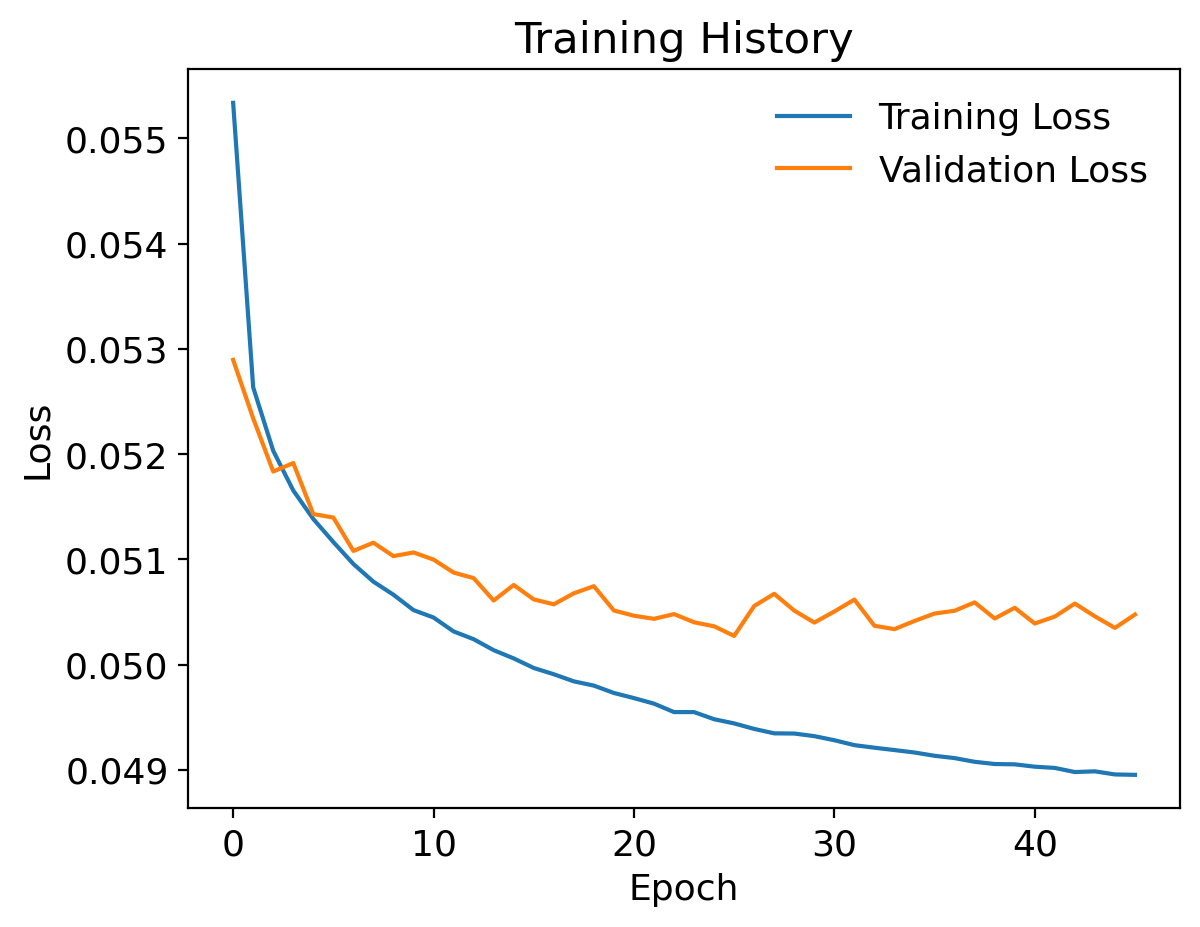

In [59]:
plot_history(train_losses, val_losses)

In [60]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [61]:
# Save the entire model to a pth file.
torch.save(model, os.path.join(model_path, 'NN_model.pth'))

In [ ]:
# reload the saved model
model = torch.load(os.path.join(model_path, 'NN_model.pth'), weights_only=False)
model.to(device).eval()

Sequential(
  (0): Linear(in_features=29, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=12, bias=True)
)

In [81]:
import numpy as np
import pandas as pd

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

model.eval()
predictions = []
with torch.no_grad():
   for batch_X, in test_loader:
       batch_X = batch_X.to(device)
       outputs = model(batch_X)
       # Convert tensor outputs to CPU and then to list (avoid .numpy())
       predictions.append(outputs.cpu().tolist())

# Concatenate list-of-lists into a single list
import itertools
y_test_pre_list = list(itertools.chain.from_iterable(predictions))

# Convert to numpy array after concatenation
y_test_pre = np.array(y_test_pre_list)

cause_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
y_pred_df = pd.DataFrame(y_test_pre, columns=cause_names)


In [82]:
# After prediction and concatenation
y_test_pre = np.concatenate(predictions, axis=0)  # shape (num_samples, 12)

cause_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
y_pred_df = pd.DataFrame(y_test_pre, columns=cause_names)

In [83]:
y_test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Calculate RMSE

In [84]:
import numpy as np

# Flatten the DataFrames to 1D arrays (optional but commonly done)
true_values = y_test_df.values.flatten()
pred_values = y_pred_df.values.flatten()

# Calculate RMSE
rmse = np.sqrt(np.mean((true_values - pred_values) ** 2))
print(f'RMSE: {rmse}')


RMSE: 0.22457049249946798


# Make Confusion Matrix

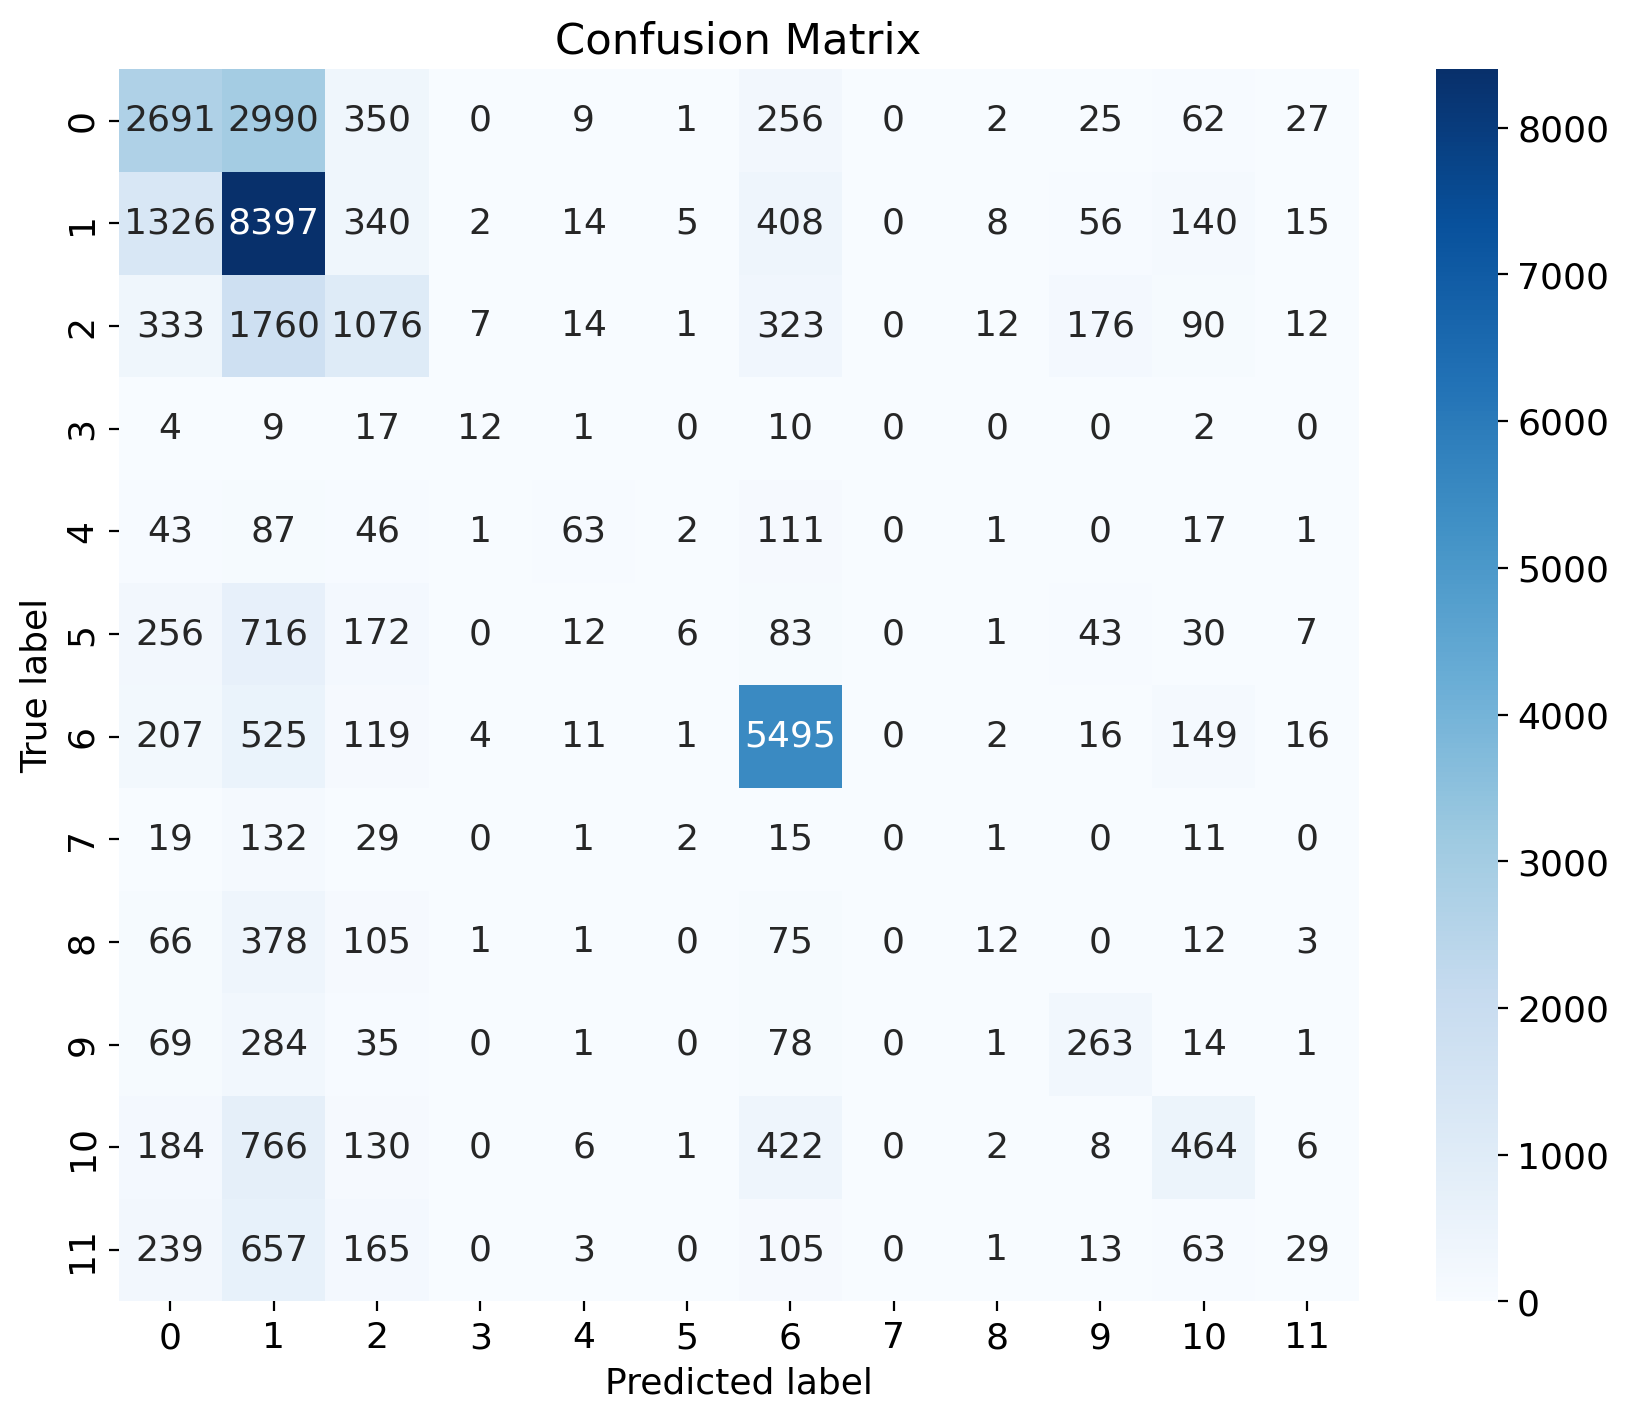

In [87]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# y_test_df and y_pred_df are your dataframes of shape (samples, 12)
# Each row: probabilistic assignment to each cause

# Get true and predicted cause labels by argmax across columns
y_true = np.argmax(y_test_df.values, axis=1)
y_pred = np.argmax(y_pred_df.values, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(12))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


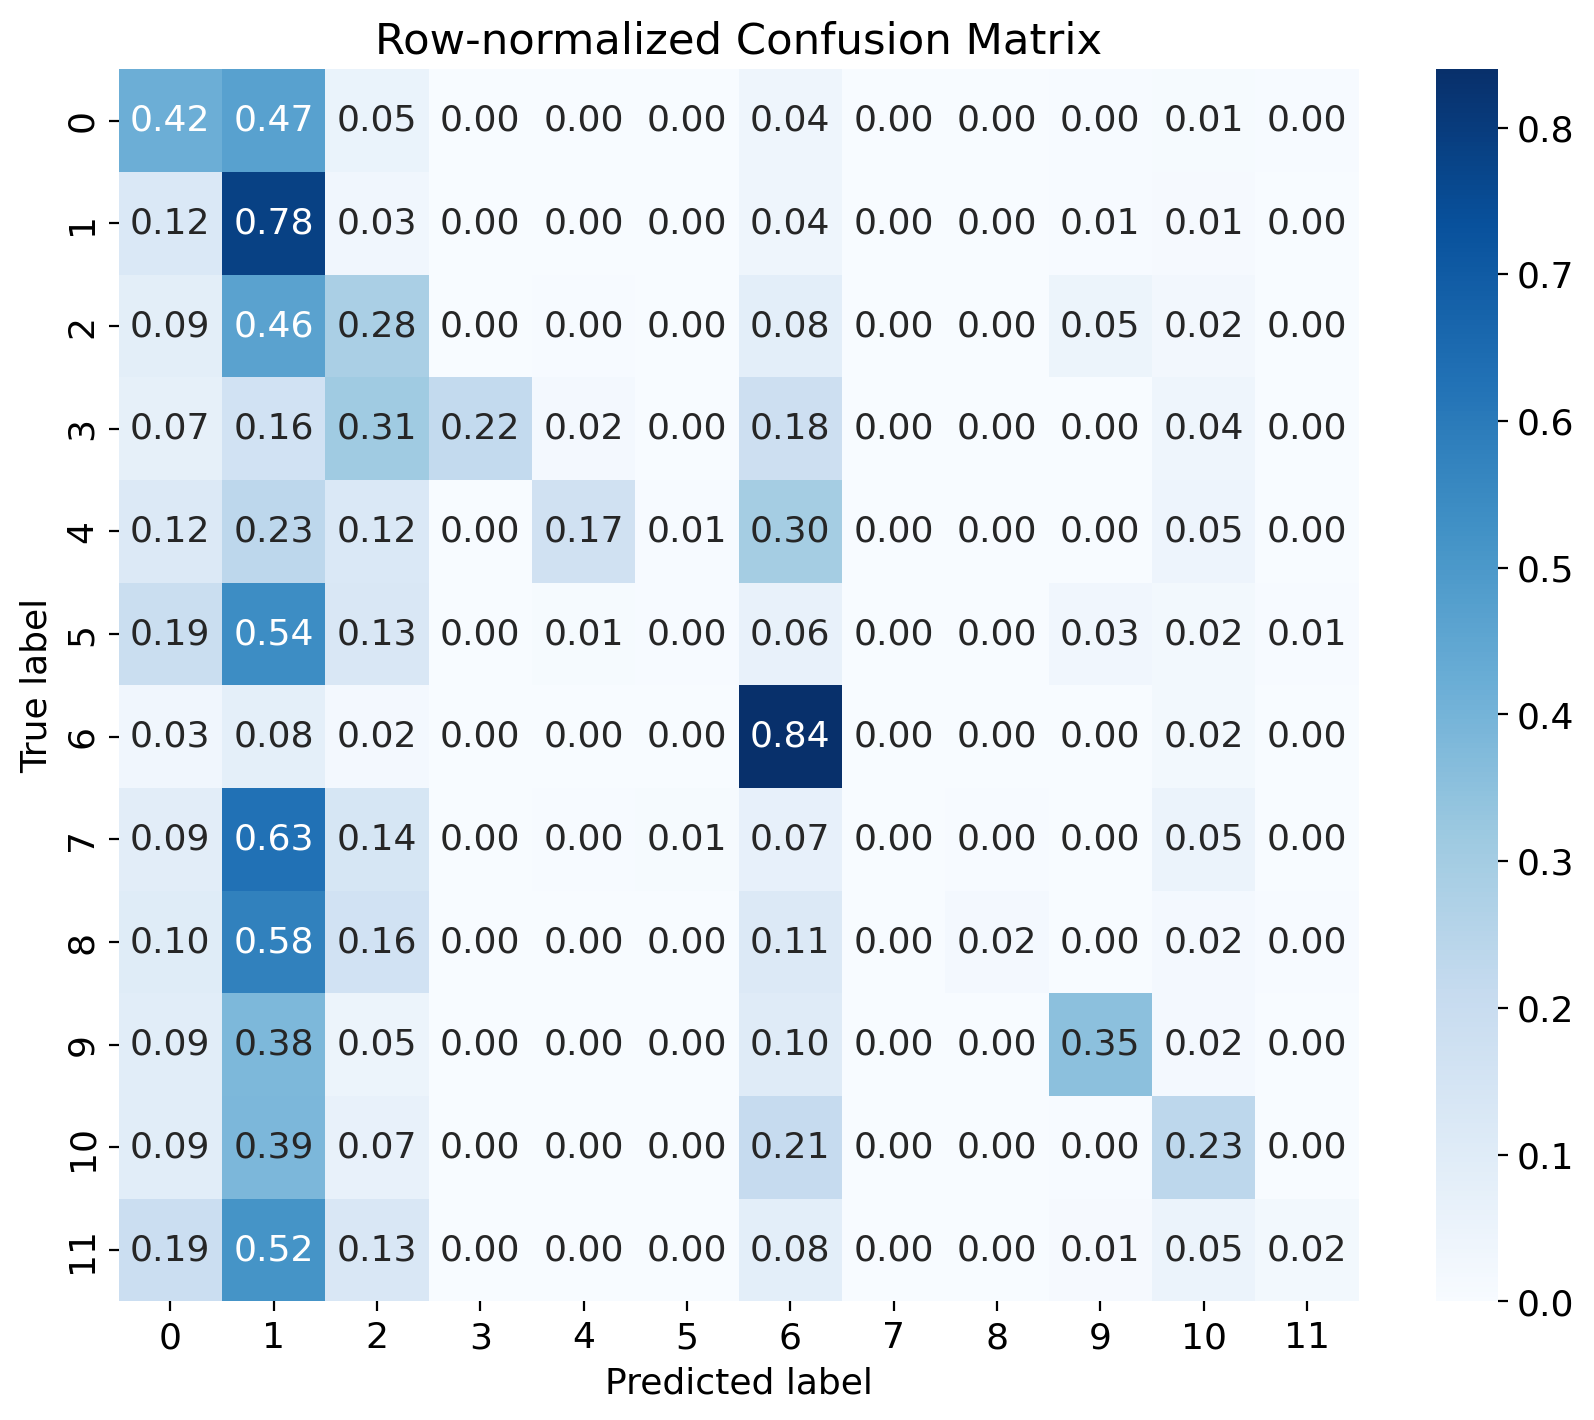

In [90]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# y_true and y_pred as before
y_true = np.argmax(y_test_df.values, axis=1)
y_pred = np.argmax(y_pred_df.values, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(12))

# Normalize so each row sums to 1 (handle zero rows to avoid division by zero)
row_sums = cm.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # avoid division by zero
cm_normalized = cm / row_sums

# Plot the normalized confusion matrix (values between 0 and 1)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=np.arange(12),
    yticklabels=np.arange(12)
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Row-normalized Confusion Matrix')
plt.show()


### Make Accuracy Matrix

In [88]:
# Calculate accuracy for each category (class-wise accuracy)
class_accuracies = cm.diagonal() / cm.sum(axis=1) *100

# Calculate overall accuracy
overall_accuracy = cm.diagonal().sum() / cm.sum()*100

# Create a DataFrame for better visualization
accuracy_table = pd.DataFrame({
    'Class': np.arange(12),
    'Class Accuracy': class_accuracies
})

# Append overall accuracy as a separate row
overall_row = pd.DataFrame({'Class': ['Overall'], 'Class Accuracy': [overall_accuracy]})
accuracy_table = pd.concat([accuracy_table, overall_row], ignore_index=True)

print(accuracy_table)

      Class  Class Accuracy
0         0       41.961640
1         1       78.396041
2         2       28.286015
3         3       21.818182
4         4       16.935484
5         5        0.452489
6         6       83.957219
7         7        0.000000
8         8        1.837672
9         9       35.254692
10       10       23.328306
11       11        2.274510
12  Overall       54.277252
